In [29]:
import os
import collections
import json
import matplotlib
font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 4}

matplotlib.rc('font', **font)

In [21]:
# Each simulation stores it's timing data in a different file. 
# Here we grab all required files.
# Note wildcards, glob.glob() etc. 
nrpoc_set = set()
import glob
bases = [
         "metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal",
         "ShifterPy3/Weak_Scaling_32_no_IO"]

def grab_files(base):
    jsonguy = collections.defaultdict(lambda: [])
    for filename in glob.glob(base+"_Res_*.json"):
        print(filename)
        with open(filename, 'r') as f:
            data = json.load(f)
            data.update(data['Other_timing'])   # add other timing to main dictionary
            splitbase = filename.split(base)
            splitfile = splitbase[1].split("_")
            res = int(splitfile[2])
#             if res==32:
#                 continue
            nproc = int(splitfile[4])
            nrpoc_set.add(nproc)
            print("VRMS = {}".format(data[u'Other_data']["vrms"]))
            jsonguy[(res,nproc)].append(data)
    return jsonguy
jsons = []
for baseguy in bases: 
    jsons.append(grab_files(baseguy))

metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_64_Nproc_8_SlurmID_3417482.json
VRMS = 0.004026318831795535
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_480_Nproc_3375_SlurmID_3417497.json
VRMS = 0.004029590469310733
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_320_Nproc_1000_SlurmID_3417496.json
VRMS = 0.004029497425986446
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_576_Nproc_5832_SlurmID_3417648.json
VRMS = 0.004029640807080965
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_256_Nproc_512_SlurmID_3417495.json
VRMS = 0.004029300403258125
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_128_Nproc_64_SlurmID_3417494.json
VRMS = 0.004028607995718459
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_640_Nproc_8000_SlurmID_3417649.json
VRMS = 0.004029620141274693
metal/Weak_Scaling_32_Shifter_Py3_NoIO_Metal_Res_32_Nproc_1_SlurmID_3417481.json
VRMS = 0.00401446103686241
ShifterPy3/Weak_Scaling_32_no_IO_Res_480_Nproc_3375_SlurmID_3068968.json
VRMS = 0.004029590469309165
Shifter

In [22]:
# Here we pick out the most expensive routines from a run
guy32 = jsons[0][(64,8)][0]
list32 = []
for key,val in guy32.items():
    if isinstance(val,list):
        list32.append([key,val[1]/float(val[0])])
sortedlist = sorted(list32, key=lambda x: x[1], reverse=True) 
funcs = []
totmax = 9
tot = 0
for guy in sortedlist:
#     if "save" in guy[0]:
#         continue
#     if "load" in guy[0]:
#         continue
#     if "FeMesh_Cartesian" in guy[0]:
#         continue
    funcs.append(guy[0])
    tot+=1
    if tot > totmax:
        break

In [23]:
funcs = [
#  'FeMesh.load()',
# #  'FeMesh.save()',
#  'MeshVariable.load()',
# #  'MeshVariable.save()',
#  'Swarm.load()',
# #  'Swarm.save()',
#  'SwarmVariable.load()',
#  'SwarmVariable.save()',
#  'Figure.save()',
 'StokesSolver.solve()',
'Python_Import_Time',
# 'Container_Launch_Time'
]

# funcs = [
# #  'FeMesh.load()',
#  'FeMesh.save()',
# #  'MeshVariable.load()',
#  'MeshVariable.save()',
# #  'Swarm.load()',
#  'Swarm.save()',
# #  'SwarmVariable.load()',
#  'SwarmVariable.save()',
# #  'Figure.save()',
#  'StokesSolver.solve()']



In [24]:
# Collect data from jsons
def collect_data_from_jsons(jsonguy):
    funcdat = collections.defaultdict(lambda: [])
    for key,data in jsonguy.items():                      # all dicts
        for func in funcs:                                # funcs we want to look at
            for datum in data:                            # all runs for each res/nproc combo
                datguy = datum[func]
                if isinstance(datguy,float):              # times explicitly added in 'Other_timing'
                                                          # do not have hit counts, so add a hit count of 1 here.
                    datguy = [ 1, datguy ]
                dat = (key[0],key[1],datguy[1]/float(datguy[0]))
                funcdat[func].append(dat)
    return funcdat
funcdats = []
for jsonguy in jsons:
    funcdats.append(collect_data_from_jsons(jsonguy))

In [25]:
# get averages if multiple datasets for given nproc/res
def get_averages(funcdatguy):
    avfuncdat = collections.defaultdict(lambda: [])
    for key, value in funcdatguy.items():
        counts = collections.defaultdict(lambda: [0,0.])
        for entry in value:
            dat = counts[entry[1]]
            dat[0]+=1
            dat[1]+=entry[2]
        for nproc, countdat in counts.items():
            avfuncdat[key].append((0,nproc,countdat[1]/float(countdat[0])))
    return avfuncdat
avfuncdats = []
for funcdat in funcdats:
    avfuncdats.append(get_averages(funcdat))

In [26]:
dats = avfuncdats

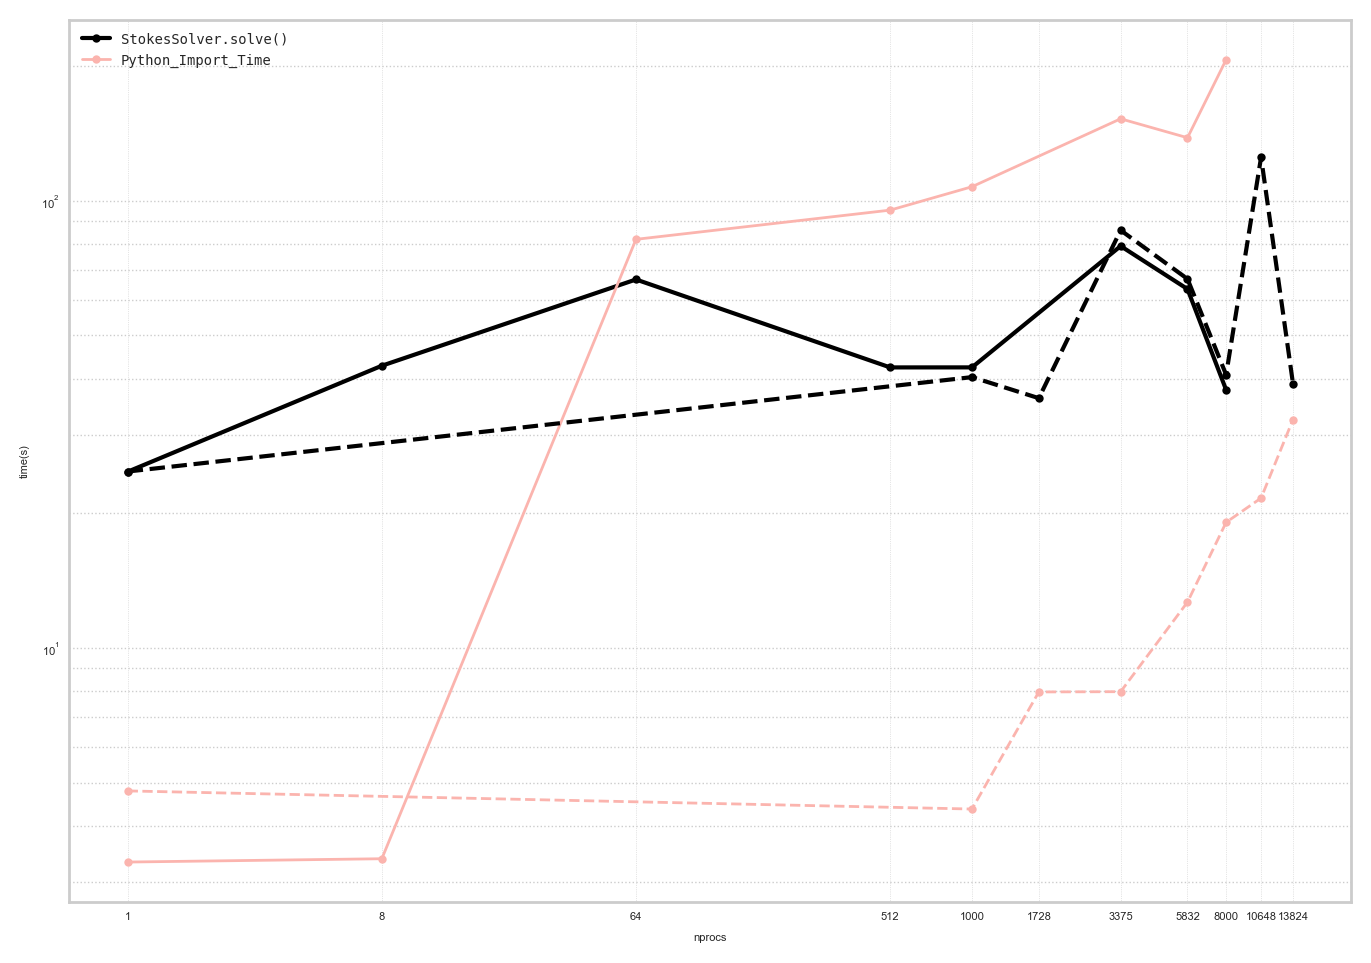

In [30]:
# plot
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure(dpi=200, figsize=(8.27, 11.69/2.))
ax = plt.subplot(1,1,1,xscale='log', yscale='log')
# ax.set_title("Save operations")
ax.set_xlabel("nprocs")
ax.set_ylabel("time(s)")
sortedprocs = sorted(list(nrpoc_set))
ax.xaxis.set_ticks(sortedprocs)
ax.xaxis.set_ticklabels(sortedprocs)
ax.grid(axis="y", which="both",linestyle=':',linewidth=0.5)
ax.grid(axis="x", which="major",linestyle=':',linewidth=0.25)
linestyles = ['-','--',':']
from matplotlib.pyplot import cm
import numpy as np
colours = cm.Pastel1_r(np.linspace(0,1,len(funcs)))

for index, dat in enumerate(dats):
    colind = 0
    for key, value in dat.items():
        xy = []
        for entry in value:
            xy.append((entry[1],entry[2]))
        sorteddat = sorted(xy, key=lambda x: x[0], reverse=False) 
        if key=='StokesSolver.solve()':
            col = "black"
            lw  = 1.5
        else:
            col = colours[colind]
            lw = 1.
        if index!=0: key=None
        ax.plot([x[0] for x in sorteddat],[x[1] for x in sorteddat], label=key, color=col, linestyle=linestyles[index], marker='o', markersize=2,linewidth=lw)
        colind+=1
ax.legend( prop={'family': 'monospace', 'size':5})

In [9]:
fig.savefig("shifter_v_metal_python_import")